# Portfolio Optimization


## Introduction

This tutorial shows how to solve the following mean-variance portfolio optimization problem for $n$ assets:

$$\begin{aligned}
\min_{x \in \{0, 1\}^n}  q x^T \Sigma x - \mu^T x\\
\text{subject to: } 1^T x = B
\end{aligned}$$

where we use the following notation:

- $x \in \{0, 1\}^n$ denotes the vector of binary decision variables, which indicate which assets to pick ($x[i] = 1$) and which not to pick ($x[i] = 0$),
- $\mu \in \mathbb{R}^n$ defines the expected returns for the assets,
- $\Sigma \in \mathbb{R}^{n \times n}$ specifies the covariances between the assets,
- $q > 0$ controls the risk appetite of the decision maker,
- and $B$ denotes the budget, i.e. the number of assets to be selected out of $n$.

We assume the following simplifications:
- all assets have the same price (normalized to 1),
- the full budget $B$ has to be spent, i.e. one has to select exactly $B$ assets.

The equality constraint $1^T x = B$ is mapped to a penalty term $(1^T x - B)^2$ which is scaled by a parameter and subtracted from the objective function. 
The resulting problem can be mapped to a Hamiltonian whose ground state corresponds to  the optimal solution.
This notebook shows how to use the Variational Quantum Eigensolver (VQE) or the Quantum Approximate Optimization Algorithm (QAOA) to find the optimal solution for a given set of parameters.

Experiments on real quantum hardware for this problem are reported for instance in the following paper:
<br>
[Improving Variational Quantum Optimization using CVaR. Barkoutsos et al. 2019.](https://arxiv.org/abs/1907.04769)

In [27]:
from qiskit import Aer
from qiskit.algorithms import VQE, QAOA, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import COBYLA
from qiskit.circuit.library import TwoLocal
from qiskit.utils import QuantumInstance
from qiskit_finance.applications.optimization import PortfolioOptimization
from qiskit_finance.data_providers import RandomDataProvider
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_optimization.applications import OptimizationApplication
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit_finance import QiskitFinanceError
from qiskit_finance.data_providers import *
from qiskit import IBMQ, assemble, transpile
from qiskit.utils import algorithm_globals
import numpy as np
import matplotlib.pyplot as plt
import datetime

### [Optional] Setup token to run the experiment on a real device
If you would like to run the experiment on a real device, you need to setup your account first.

Note: If you do not store your token yet, use `IBMQ.save_account('MY_API_TOKEN')` to store it first.

In [2]:
provider = IBMQ.load_account()

provider = IBMQ.get_provider(hub='ibm-q')
for backend in provider.backends():
    print(backend)

for backend in provider.backends():
    print(backend.status().to_dict())


ibmq_qasm_simulator
ibmq_armonk
ibmq_santiago
ibmq_bogota
ibmq_lima
ibmq_belem
ibmq_quito
simulator_statevector
simulator_mps
simulator_extended_stabilizer
simulator_stabilizer
ibmq_manila
{'backend_name': 'ibmq_qasm_simulator', 'backend_version': '0.1.547', 'operational': True, 'pending_jobs': 1, 'status_msg': 'active'}
{'backend_name': 'ibmq_armonk', 'backend_version': '2.4.16', 'operational': True, 'pending_jobs': 2, 'status_msg': 'active'}
{'backend_name': 'ibmq_santiago', 'backend_version': '1.3.31', 'operational': True, 'pending_jobs': 556, 'status_msg': 'active'}
{'backend_name': 'ibmq_bogota', 'backend_version': '1.4.47', 'operational': True, 'pending_jobs': 13, 'status_msg': 'active'}
{'backend_name': 'ibmq_lima', 'backend_version': '1.0.17', 'operational': True, 'pending_jobs': 56, 'status_msg': 'active'}
{'backend_name': 'ibmq_belem', 'backend_version': '1.0.19', 'operational': True, 'pending_jobs': 10, 'status_msg': 'active'}
{'backend_name': 'ibmq_quito', 'backend_version'

In [4]:
#backend = provider.get_backend('ibmq_santiago')

backend = Aer.get_backend('statevector_simulator')



## Define problem instance

Here an Operator instance is created for our Hamiltonian. In this case the paulis are from an Ising Hamiltonian translated from the portfolio problem. We use a random portfolio problem for this notebook. It is straight-forward to extend this to using real financial data as illustrated here:<br>
[Loading and Processing Stock-Market Time-Series Data](11_time_series.ipynb)

In [12]:
## Load Stock market Data 
stocks = ["AEO", "AAPL", "AEP", "AAL"]
try:
    data = YahooDataProvider(
                 tickers = stocks,
                 start=datetime.datetime(2018, 1, 1),
                 end=datetime.datetime(2018, 12, 31))
    data.run()
except QiskitFinanceError as ex:
    data = None
    print(ex)

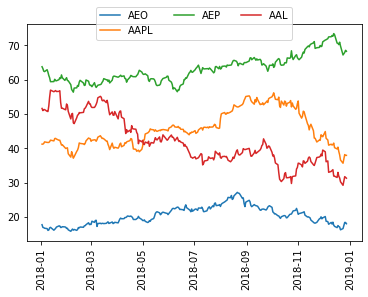

In [13]:
#Plot Tickers over the time period


for (cnt, s) in enumerate(data._tickers):
    plt.plot(data._data[cnt], label=s)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=3)
plt.xticks(rotation=90)
plt.show()

In [14]:
# # set number of assets (= number of qubits)
# num_assets = 4
# seed = 124

# # Generate expected return and covariance matrix from (random) time-series
# stocks = [("TICKER%s" % i) for i in range(num_assets)]


In [15]:
# data = RandomDataProvider(tickers=stocks,
#                  start=datetime.datetime(2016,1,1),
#                  end=datetime.datetime(2016,1,30),
#                  seed=seed)
# data.run()


## Stock statistics
Calculate a vector containing the expected returns of each asset 

Calculate an asset to asset covarience matrix 


In [16]:
mu = data.get_period_return_mean_vector()
sigma = data.get_period_return_covariance_matrix()

In [17]:
print(stocks)
print(mu)

['AEO', 'AAPL', 'AEP', 'AAL']
[ 0.00036426 -0.00016844  0.0003331  -0.00168564]


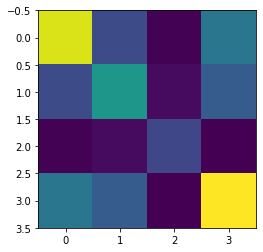

In [18]:
# plot sigma
plt.imshow(sigma, interpolation='nearest')
plt.show()

In [20]:
q = 0.5 
num_assets = 4
seed = 123# set risk factor
budget = num_assets // 2  # set budget
penalty = num_assets      # set parameter to scale the budget penalty term

portfolio = PortfolioOptimization(expected_returns=mu, covariances=sigma, risk_factor=q, budget=budget)
qp = portfolio.to_quadratic_program()
qp

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Portfolio optimization

Minimize
 obj: - 0.000364255202 x_0 + 0.000168443812 x_1 - 0.000333095920 x_2
      + 0.001685642503 x_3 + [ 0.000601984317 x_0^2 + 0.000262602553 x_0*x_1
      - 0.000036389186 x_0*x_2 + 0.000477436995 x_0*x_3 + 0.000328770936 x_1^2
      - 0.000003618416 x_1*x_2 + 0.000339923631 x_1*x_3 + 0.000118412389 x_2^2
      - 0.000042152042 x_2*x_3 + 0.000639674444 x_3^2 ]/2
Subject To
 c0: x_0 + x_1 + x_2 + x_3 = 2

Bounds
 0 <= x_0 <= 1
 0 <= x_1 <= 1
 0 <= x_2 <= 1
 0 <= x_3 <= 1

Binaries
 x_0 x_1 x_2 x_3
End

We define some utility methods to print the results in a nice format.

In [21]:
def index_to_selection(i, num_assets):
    s = "{0:b}".format(i).rjust(num_assets)
    x = np.array([1 if s[i]=='1' else 0 for i in reversed(range(num_assets))])
    return x

def print_result(result):
    selection = result.x
    value = result.fval
    print('Optimal: selection {}, value {:.4f}'.format(selection, value))
    
    eigenstate = result.min_eigen_solver_result.eigenstate
    eigenvector = eigenstate if isinstance(eigenstate, np.ndarray) else eigenstate.to_matrix()
    probabilities = np.abs(eigenvector)**2
    i_sorted = reversed(np.argsort(probabilities))
    print('\n----------------- Full result ---------------------')
    print('selection\tvalue\t\tprobability')
    print('---------------------------------------------------')
    for i in i_sorted:
        x = index_to_selection(i, num_assets)
        value = QuadraticProgramToQubo().convert(qp).objective.evaluate(x)
        #value = portfolio.to_quadratic_program().objective.evaluate(x)
        probability = probabilities[i]
        print('%10s\t%.4f\t\t%.4f' %(x, value, probability))

## NumPyMinimumEigensolver (as a classical reference)
Lets solve the problem. First classically...

We can now use the Operator we built above without regard to the specifics of how it was created. We set the algorithm for the NumPyMinimumEigensolver so we can have a classical reference. The problem is set for 'ising'. Backend is not required since this is computed classically not using quantum computation. The result is returned as a dictionary.

In [22]:
exact_mes = NumPyMinimumEigensolver()
exact_eigensolver = MinimumEigenOptimizer(exact_mes)

result = exact_eigensolver.solve(qp)

print_result(result)

Optimal: selection [1. 0. 1. 0.], value -0.0004

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
 [1 0 1 0]	-0.0004		1.0000
 [1 1 1 1]	4.0184		0.0000
 [0 1 1 1]	1.0062		0.0000
 [1 0 1 1]	1.0058		0.0000
 [0 0 1 1]	0.0017		0.0000
 [1 1 0 1]	1.0068		0.0000
 [0 1 0 1]	0.0025		0.0000
 [1 0 0 1]	0.0022		0.0000
 [0 0 0 1]	1.0060		0.0000
 [1 1 1 0]	1.0041		0.0000
 [0 1 1 0]	0.0001		0.0000
 [0 0 1 0]	1.0037		0.0000
 [1 1 0 0]	0.0004		0.0000
 [0 1 0 0]	1.0043		0.0000
 [1 0 0 0]	1.0039		0.0000
 [0 0 0 0]	4.0159		0.0000


## Solution using VQE
We can now use the Variational Quantum Eigensolver (VQE) to solve the problem. We will specify the optimizer and variational form to be used.

Note: You can switch to different backends by providing the name of backend.

In [23]:
## Classical Optimiser 
cobyla = COBYLA()
cobyla.set_options(maxiter=5)

The two-local circuit.

The two-local circuit is a parameterized circuit consisting of alternating rotation layers and entanglement layers. The rotation layers are single qubit gates applied on all qubits. The entanglement layer uses two-qubit gates to entangle the qubits according to a strategy set using entanglement. Both the rotation and entanglement gates can be specified as string (e.g. 'ry' or 'cx'), as gate-type (e.g. RYGate or CXGate) or as QuantumCircuit (e.g. a 1-qubit circuit or 2-qubit circuit).provider = IBMQ.load_account()



In [24]:
#ry == Ansatz
ry = TwoLocal(num_assets, 'ry', 'cz', reps=3, entanglement='full')
print(ry)

     ┌──────────┐            ┌──────────┐                                 »
q_0: ┤ Ry(θ[0]) ├─■──■─────■─┤ Ry(θ[4]) ├─────────────────■───────■─────■─»
     ├──────────┤ │  │     │ └──────────┘┌──────────┐     │       │     │ »
q_1: ┤ Ry(θ[1]) ├─■──┼──■──┼──────■──────┤ Ry(θ[5]) ├─────■───────┼──■──┼─»
     ├──────────┤    │  │  │      │      └──────────┘┌──────────┐ │  │  │ »
q_2: ┤ Ry(θ[2]) ├────■──■──┼──────┼───────────■──────┤ Ry(θ[6]) ├─■──■──┼─»
     ├──────────┤          │      │           │      ├──────────┤       │ »
q_3: ┤ Ry(θ[3]) ├──────────■──────■───────────■──────┤ Ry(θ[7]) ├───────■─»
     └──────────┘                                    └──────────┘         »
«     ┌──────────┐                                  ┌───────────┐             »
«q_0: ┤ Ry(θ[8]) ├──────────────────■───────■─────■─┤ Ry(θ[12]) ├─────────────»
«     └──────────┘┌──────────┐      │       │     │ └───────────┘┌───────────┐»
«q_1: ─────■──────┤ Ry(θ[9]) ├──────■───────┼──■──┼───────■──────┤ Ry(θ[13])

In [25]:
#Variation Quantum Eigensolver 

quantum_instance = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed)
vqe_mes = VQE(ry, optimizer=cobyla, quantum_instance=quantum_instance)
vqe = MinimumEigenOptimizer(vqe_mes)
result = vqe.solve(qp)

print_result(result)

Optimal: selection [1. 0. 1. 0.], value -0.0004

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
 [0 0 1 0]	1.0037		0.2795
 [0 0 1 1]	0.0017		0.1366
 [1 0 1 0]	-0.0004		0.0936
 [1 1 1 0]	1.0041		0.0777
 [1 0 0 0]	1.0039		0.0698
 [1 0 0 1]	0.0022		0.0644
 [0 1 0 0]	1.0043		0.0611
 [0 1 1 1]	1.0062		0.0529
 [0 1 1 0]	0.0001		0.0528
 [0 0 0 0]	4.0159		0.0359
 [1 1 0 1]	1.0068		0.0217
 [1 0 1 1]	1.0058		0.0194
 [1 1 1 1]	4.0184		0.0172
 [0 0 0 1]	1.0060		0.0100
 [1 1 0 0]	0.0004		0.0058
 [0 1 0 1]	0.0025		0.0015


### Solution using QAOA

We also show here a result using the Quantum Approximate Optimization Algorithm (QAOA). This is another variational algorithm and it uses an internal variational form that is created based on the problem.

In [28]:
algorithm_globals.random_seed = 1234
#backend = Aer.get_backend('statevector_simulator')

cobyla = COBYLA()
cobyla.set_options(maxiter=250)
quantum_instance = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed)
qaoa_mes = QAOA(optimizer=cobyla, reps=3, quantum_instance=quantum_instance)
qaoa = MinimumEigenOptimizer(qaoa_mes)
result = qaoa.solve(qp)

print_result(result)

Optimal: selection [1. 0. 1. 0.], value -0.0004

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
 [1 0 1 0]	-0.0004		0.1684
 [0 1 1 0]	0.0001		0.1679
 [1 1 0 0]	0.0004		0.1674
 [0 0 1 1]	0.0017		0.1659
 [1 0 0 1]	0.0022		0.1654
 [0 1 0 1]	0.0025		0.1650
 [1 1 0 1]	1.0068		0.0000
 [0 0 0 1]	1.0060		0.0000
 [1 1 1 0]	1.0041		0.0000
 [0 0 0 0]	4.0159		0.0000
 [1 1 1 1]	4.0184		0.0000
 [0 0 1 0]	1.0037		0.0000
 [0 1 1 1]	1.0062		0.0000
 [1 0 0 0]	1.0039		0.0000
 [1 0 1 1]	1.0058		0.0000
 [0 1 0 0]	1.0043		0.0000


In [9]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright